# Installations and imports

In [96]:
!pip install torchinfo

In [97]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms, models
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat
import numpy as np
from shutil import copyfile
from typing import Tuple, List, Any, Union, Dict
from IPython.display import display
import albumentations as A
import cv2
import glob
from typing import List
import pickle

# Dataset Preparation

## custom dataset for training and transformations

In [98]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform):
        """
        Args:
            data (list of tuples): A list of (image_path, label) pairs.
            transform (callable): A function/transform to apply to the images.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Fetches the sample (image, label) at the given index.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            image (Tensor): The transformed image.
            label (int): The corresponding label.
        """
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def save(self, filepath):
        with open(filepath, 'wb') as f:
            pickle.dump(self.__dict__, f)

    def load(self, filepath):
        with open(filepath, 'rb') as f:
            tmp_dict = pickle.load(f)
        self.__dict__.update(tmp_dict)

## create augmentations

In [99]:
def get_aug_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=30, border_mode=cv2.BORDER_WRAP, p=0.5, fit_output=True),  # Arbitrary rotation (fixes black gaps)
        A.RandomBrightnessContrast(p=0.4),
        A.GaussianBlur(blur_limit=3, p=0.3),
        A.Affine(scale=(0.8, 1.2), translate_percent=(0.1, 0.3), shear=(-10, 10), p=0.5, border_mode=cv2.BORDER_WRAP),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    ])

In [100]:
random.seed(None) # for different augmentations

def pad_and_resize(image, padding=50):
    """ Adds extra padding to the image and ensures it resizes back to the target size after augmentation. """
    padded_image = cv2.copyMakeBorder(image, padding, padding, padding, padding, cv2.BORDER_REPLICATE)
    return padded_image

def remove_black_regions(image):
    """ Uses inpainting to remove any remaining black areas. """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mask = (gray == 0).astype(np.uint8) * 255  # Detect black pixels
    if np.any(mask):
        image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return image

def resize_back(image, target_size=224):
    """ Resizes back to the target size after augmentation to remove any black gaps. """
    return cv2.resize(image, target_size, interpolation=cv2.INTER_LANCZOS4)

def create_augmentations(image_path, dest_path, num_augmentations=10, padding=100) -> List[str]:
    print(f"imgae_path: {image_path}, dest_path: {dest_path}")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    orig_h, orig_w = image.shape[:2]

    image_padded = pad_and_resize(image, padding)  # Extra padding before transformation

    augmented_paths = []
    for i in range(num_augmentations):
        aug_pipeline = get_aug_pipeline()

        # Apply augmentation
        augmented = aug_pipeline(image=image_padded)
        cleaned_image = remove_black_regions(augmented["image"])

        final_image = resize_back(cleaned_image, target_size=(orig_w, orig_h))

        # Save augmented image
        base_name, ext = os.path.splitext(os.path.basename(image_path))
        augmented_filename = f"{base_name}_aug_{i}{ext}"
        augmented_image_path = os.path.join(dest_path, augmented_filename)
        cv2.imwrite(augmented_image_path, cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR))  # Convert back to BGR for saving
        augmented_paths.append(augmented_image_path)

    return augmented_paths

## preprocess pipeline
- downloading data
- organizing in directories for Yolo
- organizing in splits for dataloaders for VGG

In [101]:
# Ensure reproducibility
random.seed(42)
torch.manual_seed(42)

# Dataset configuration
DATA_DIR = "flowers102"  # Directory where flower images are stored
DATASET_DIR = f"{DATA_DIR}/dataset"
IMG_SIZE = (224, 224)
NUM_CLASSES = 102  # 102 flower categories

# Download the dataset if not already available
def download_and_prepare_dataset():
    if not os.path.exists(DATA_DIR):
        os.system(f"wget -P {DATA_DIR} https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz")
        os.system(f"wget -P {DATA_DIR} https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat")
        os.system(f"tar -xvzf {DATA_DIR}/102flowers.tgz -C {DATA_DIR}")

    # Create dataset directory structure
    os.makedirs(DATASET_DIR, exist_ok=True)
    for split in ["train", "val", "test"]:
        split_dir = os.path.join(DATASET_DIR, split) if split != "test" else os.path.join(DATA_DIR, "test")
        os.makedirs(split_dir, exist_ok=True)
        for class_idx in range(NUM_CLASSES):
            class_dir = os.path.join(split_dir, str(class_idx))
            os.makedirs(class_dir, exist_ok=True)

# Data preprocessing
def preprocess_data() -> Tuple[CustomDataset, CustomDataset, CustomDataset]:
    # Load labels from the imagelabels.mat file
    labels_file = os.path.join(DATA_DIR, "imagelabels.mat")
    labels_data = loadmat(labels_file)
    labels = labels_data["labels"].squeeze() - 1

    # Get list of all image paths in the correct order
    image_paths = [os.path.join(os.path.join(DATA_DIR, "jpg"), f"image_{i:05d}.jpg") for i in range(1, len(labels) + 1)]

    image_train, image_temp, label_train, label_temp = train_test_split(
        image_paths, labels, test_size=0.5, stratify=labels, random_state=42
    )

    # Then, split the temp set into validation (25%) and test (25%) sets
    image_val, image_test, label_val, label_test = train_test_split(
        image_temp, label_temp, test_size=0.5, stratify=label_temp, random_state=42
    )

    train_data = []
    val_data = []
    test_data = []

    for image_path, label in zip(image_train, label_train):
        dest_dir = os.path.join(DATASET_DIR, "train")
        copyfile(image_path, os.path.join(dest_dir, str(label), os.path.basename(image_path)))
        augmentation_paths = create_augmentations(image_path, os.path.join(dest_dir, str(label)))
        train_data.append((os.path.join(dest_dir, str(label), os.path.basename(image_path)), label))
        train_data.extend([(aug_path, label) for aug_path in augmentation_paths])

    for image_path, label in zip(image_val, label_val):
        dest_dir = os.path.join(DATASET_DIR, "val")
        val_data.append((os.path.join(dest_dir, str(label), os.path.basename(image_path)), label))
        copyfile(image_path, os.path.join(dest_dir, str(label), os.path.basename(image_path)))

    for image_path, label in zip(image_test, label_test):
        # test is kept in a separate dir, so yolo won't use it for finetuning
        dest_dir = os.path.join(DATA_DIR, "test")
        test_data.append((os.path.join(dest_dir, str(label), os.path.basename(image_path)), label))
        copyfile(image_path, os.path.join(dest_dir, str(label), os.path.basename(image_path)))


    # Normalization values are chosen based on the ImageNet dataset mean and std - for Vgg19
    transform = transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.CenterCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Convert the splits into PyTorch datasets
    train_dataset = CustomDataset(train_data, transform)
    val_dataset = CustomDataset(val_data, transform)
    test_dataset = CustomDataset(test_data, transform)

    os.makedirs("/content/saved_datasets/", exist_ok=True)
    train_dataset.save("/content/saved_datasets/train")
    val_dataset.save("/content/saved_datasets/val")
    test_dataset.save("/content/saved_datasets/test")

    return train_dataset, val_dataset, test_dataset

In [23]:
download_and_prepare_dataset()

In [27]:
random_splits = preprocess_data()

imgae_path: flowers102/jpg/image_02919.jpg, dest_path: flowers102/dataset/train/85
imgae_path: flowers102/jpg/image_00464.jpg, dest_path: flowers102/dataset/train/87
imgae_path: flowers102/jpg/image_01827.jpg, dest_path: flowers102/dataset/train/77
imgae_path: flowers102/jpg/image_08015.jpg, dest_path: flowers102/dataset/train/101
imgae_path: flowers102/jpg/image_04874.jpg, dest_path: flowers102/dataset/train/90
imgae_path: flowers102/jpg/image_02466.jpg, dest_path: flowers102/dataset/train/75
imgae_path: flowers102/jpg/image_06777.jpg, dest_path: flowers102/dataset/train/20
imgae_path: flowers102/jpg/image_07047.jpg, dest_path: flowers102/dataset/train/66
imgae_path: flowers102/jpg/image_07317.jpg, dest_path: flowers102/dataset/train/93
imgae_path: flowers102/jpg/image_06756.jpg, dest_path: flowers102/dataset/train/0
imgae_path: flowers102/jpg/image_04869.jpg, dest_path: flowers102/dataset/train/90
imgae_path: flowers102/jpg/image_01215.jpg, dest_path: flowers102/dataset/train/73
imga

# Build models

## vgg19

In [102]:
# Build and fine-tune VGG19 model
def build_vgg19_model():
    # Load the VGG19 model pretrained on ImageNet
    model = models.vgg19(pretrained=True)

    # Freeze the convolutional layers to use them as feature extractors
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace the fully connected layer to adapt it to 102 flower categories
    # The choice of 4096 is based on the VGG19 architecture where the FC layer has 4096 units
    model.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    return model

In [103]:
from IPython.display import display

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    display(f"model is trained with {device}")
    model = model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            if isinstance(inputs, list):
                inputs = torch.cat(inputs, dim=0)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        val_acc, val_loss = validate_model(model, val_loader, criterion, device)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        display(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return model, train_losses, train_accuracies, val_losses, val_accuracies

# Validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total, running_loss / len(val_loader)


def evaluate_model(model, test_loader, num_classes=102):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    overall_accuracies = []
    class_accuracies = []

    model.to(device)
    model.eval()

    correct = 0
    total = 0
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted class

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Track per-class accuracy
            for i in range(labels.size(0)):
                label = labels[i].item()
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1

            # Store for confusion matrix
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute overall accuracy
    overall_accuracy = 100 * correct / total
    overall_accuracies.append(overall_accuracy)

    # Compute class-wise accuracy and store in DataFrame
    class_accuracy = 100 * (class_correct / class_total)
    class_accuracy_df = pd.DataFrame({"acc": class_accuracy})
    class_accuracies.append(class_accuracy_df)

    display(f"\nOverall Accuracy: {overall_accuracy:.2f}%\n")
    for i in range(num_classes):
        print(f"Class {i} Accuracy: {class_accuracy[i]:.2f}%")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(30, 30))  # Explicitly create figure and axes
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(num_classes)])
    disp.plot(cmap="Blues", values_format="d", ax=ax)
    plt.title(f"Confusion Matrix (Accuracy: {overall_accuracy:.2f}%)", fontsize=16)
    plt.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # plt.tight_layout()
    image_path = "confusion_mat_plot.png"

    plt.savefig(image_path, format="png", bbox_inches="tight")
    plt.close()
    display(Image.open(image_path))

## yolov5
as for now we just clone the repo for later use.

In [35]:
!git clone https://github.com/ultralytics/yolov5.git
!cd yolov5
!pip install -r /content/yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17270, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 17270 (delta 0), reused 0 (delta 0), pack-reused 17265 (from 1)
Receiving objects: 100% (17270/17270), 16.12 MiB | 17.10 MiB/s, done.
Resolving deltas: 100% (11858/11858), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━

# Visualizations

In [104]:
# Plotting function for training statistics
def plot_training_statistics(train_losses, train_accuracies, val_losses, val_accuracies):
  epochs = range(1, len(train_losses) + 1)

  # Plot training loss
  plt.figure()
  plt.plot(epochs, train_losses, label="Train Loss")
  plt.plot(epochs, val_losses, label="Validation Loss")
  plt.title("Train and Validation Loss Over Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  # plt.show()
  loss_image_path = "training_loss_plot.png"

  plt.savefig(loss_image_path, format="png", bbox_inches="tight")
  plt.close()
  display(Image.open(loss_image_path))

  # Plot training and validation accuracy
  plt.figure()
  plt.plot(epochs, train_accuracies, label="Train Accuracy")
  plt.plot(epochs, val_accuracies, label="Validation Accuracy")
  plt.title("Train and Validation Accuracy Over Epochs")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy (%)")
  plt.legend()
  # plt.show()
  acc_image_path = "training_acc_plot.png"

  plt.savefig(acc_image_path, format="png", bbox_inches="tight")
  plt.close()
  display(Image.open(acc_image_path))

# Let the game begin!

## load data

this cell is for fast load, only if needed. otherwise just skip it

In [105]:
train_dataset = CustomDataset([], None)
train_dataset.load("/content/saved_datasets/train")

val_dataset = CustomDataset([], None)
val_dataset.load("/content/saved_datasets/val")

test_dataset = CustomDataset([], None)
test_dataset.load("/content/saved_datasets/test")

In [106]:
BATCH_SIZE = 32

# train_dataset, val_dataset, test_dataset = random_splits
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## train vgg19

In [107]:
display("Training VGG19 model...")
vgg19_model = build_vgg19_model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=5e-6, weight_decay=1e-4)
vgg19_model, vgg_train_losses, vgg_train_accuracies, vgg_val_losses, vgg_val_accuracies = train_model(vgg19_model, train_loader, val_loader, criterion, optimizer, epochs=20)

'Training VGG19 model...'

'model is trained with cuda'

'Epoch 1/20, Train Loss: 3.5028, Train Acc: 21.74%, Val Loss: 1.9541, Val Acc: 59.60%'

'Epoch 2/20, Train Loss: 1.8881, Train Acc: 52.38%, Val Loss: 1.1551, Val Acc: 73.86%'

'Epoch 3/20, Train Loss: 1.3310, Train Acc: 64.58%, Val Loss: 0.8756, Val Acc: 78.80%'

'Epoch 4/20, Train Loss: 1.0270, Train Acc: 72.02%, Val Loss: 0.7366, Val Acc: 81.34%'

'Epoch 5/20, Train Loss: 0.8249, Train Acc: 77.43%, Val Loss: 0.6532, Val Acc: 83.34%'

'Epoch 6/20, Train Loss: 0.6655, Train Acc: 81.50%, Val Loss: 0.6018, Val Acc: 84.07%'

'Epoch 7/20, Train Loss: 0.5406, Train Acc: 85.21%, Val Loss: 0.5588, Val Acc: 85.54%'

'Epoch 8/20, Train Loss: 0.4408, Train Acc: 87.90%, Val Loss: 0.5350, Val Acc: 85.98%'

'Epoch 9/20, Train Loss: 0.3660, Train Acc: 90.07%, Val Loss: 0.5185, Val Acc: 85.88%'

'Epoch 10/20, Train Loss: 0.3054, Train Acc: 91.81%, Val Loss: 0.5009, Val Acc: 87.35%'

'Epoch 11/20, Train Loss: 0.2476, Train Acc: 93.48%, Val Loss: 0.4917, Val Acc: 86.91%'

'Epoch 12/20, Train Loss: 0.2055, Train Acc: 94.68%, Val Loss: 0.4945, Val Acc: 87.15%'

'Epoch 13/20, Train Loss: 0.1647, Train Acc: 95.93%, Val Loss: 0.4825, Val Acc: 87.30%'

'Epoch 14/20, Train Loss: 0.1349, Train Acc: 96.80%, Val Loss: 0.4883, Val Acc: 86.91%'

'Epoch 15/20, Train Loss: 0.1086, Train Acc: 97.55%, Val Loss: 0.4849, Val Acc: 87.40%'

'Epoch 16/20, Train Loss: 0.0893, Train Acc: 98.11%, Val Loss: 0.4901, Val Acc: 87.15%'

'Epoch 17/20, Train Loss: 0.0746, Train Acc: 98.49%, Val Loss: 0.4870, Val Acc: 87.45%'

'Epoch 18/20, Train Loss: 0.0615, Train Acc: 98.83%, Val Loss: 0.4834, Val Acc: 88.03%'

'Epoch 19/20, Train Loss: 0.0508, Train Acc: 99.10%, Val Loss: 0.4893, Val Acc: 87.69%'

'Epoch 20/20, Train Loss: 0.0429, Train Acc: 99.29%, Val Loss: 0.4956, Val Acc: 87.84%'

In [108]:
from torchinfo import summary
model_summary = summary(vgg19_model, input_size=(1, 3, 224, 224), depth=10, col_names=["input_size", "output_size", "num_params"], verbose=0)

# Write summary to a text file
with open("vgg19_summary.txt", "w") as f:
    f.write(str(model_summary))

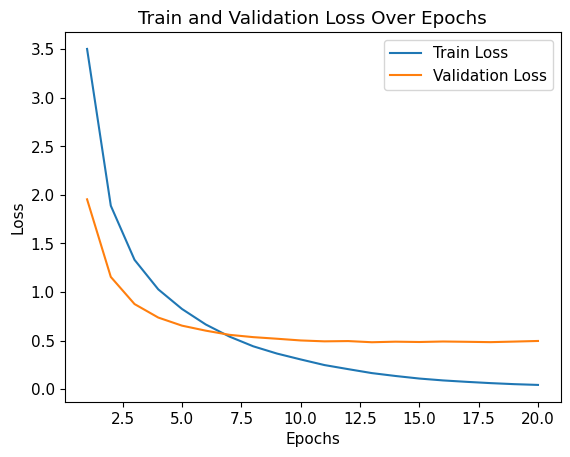

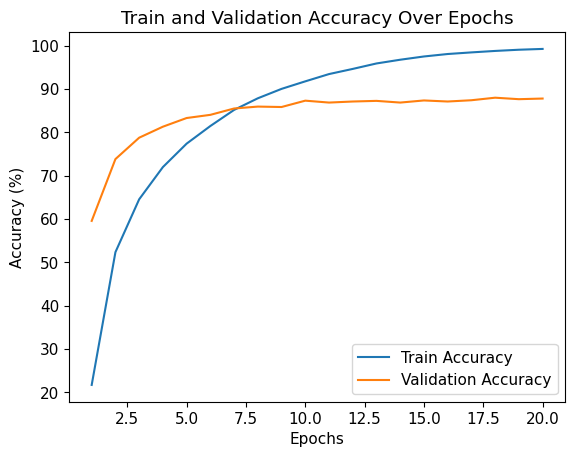

In [109]:
plot_training_statistics(vgg_train_losses, vgg_train_accuracies, vgg_val_losses, vgg_val_accuracies)

'\nOverall Accuracy: 86.96%\n'

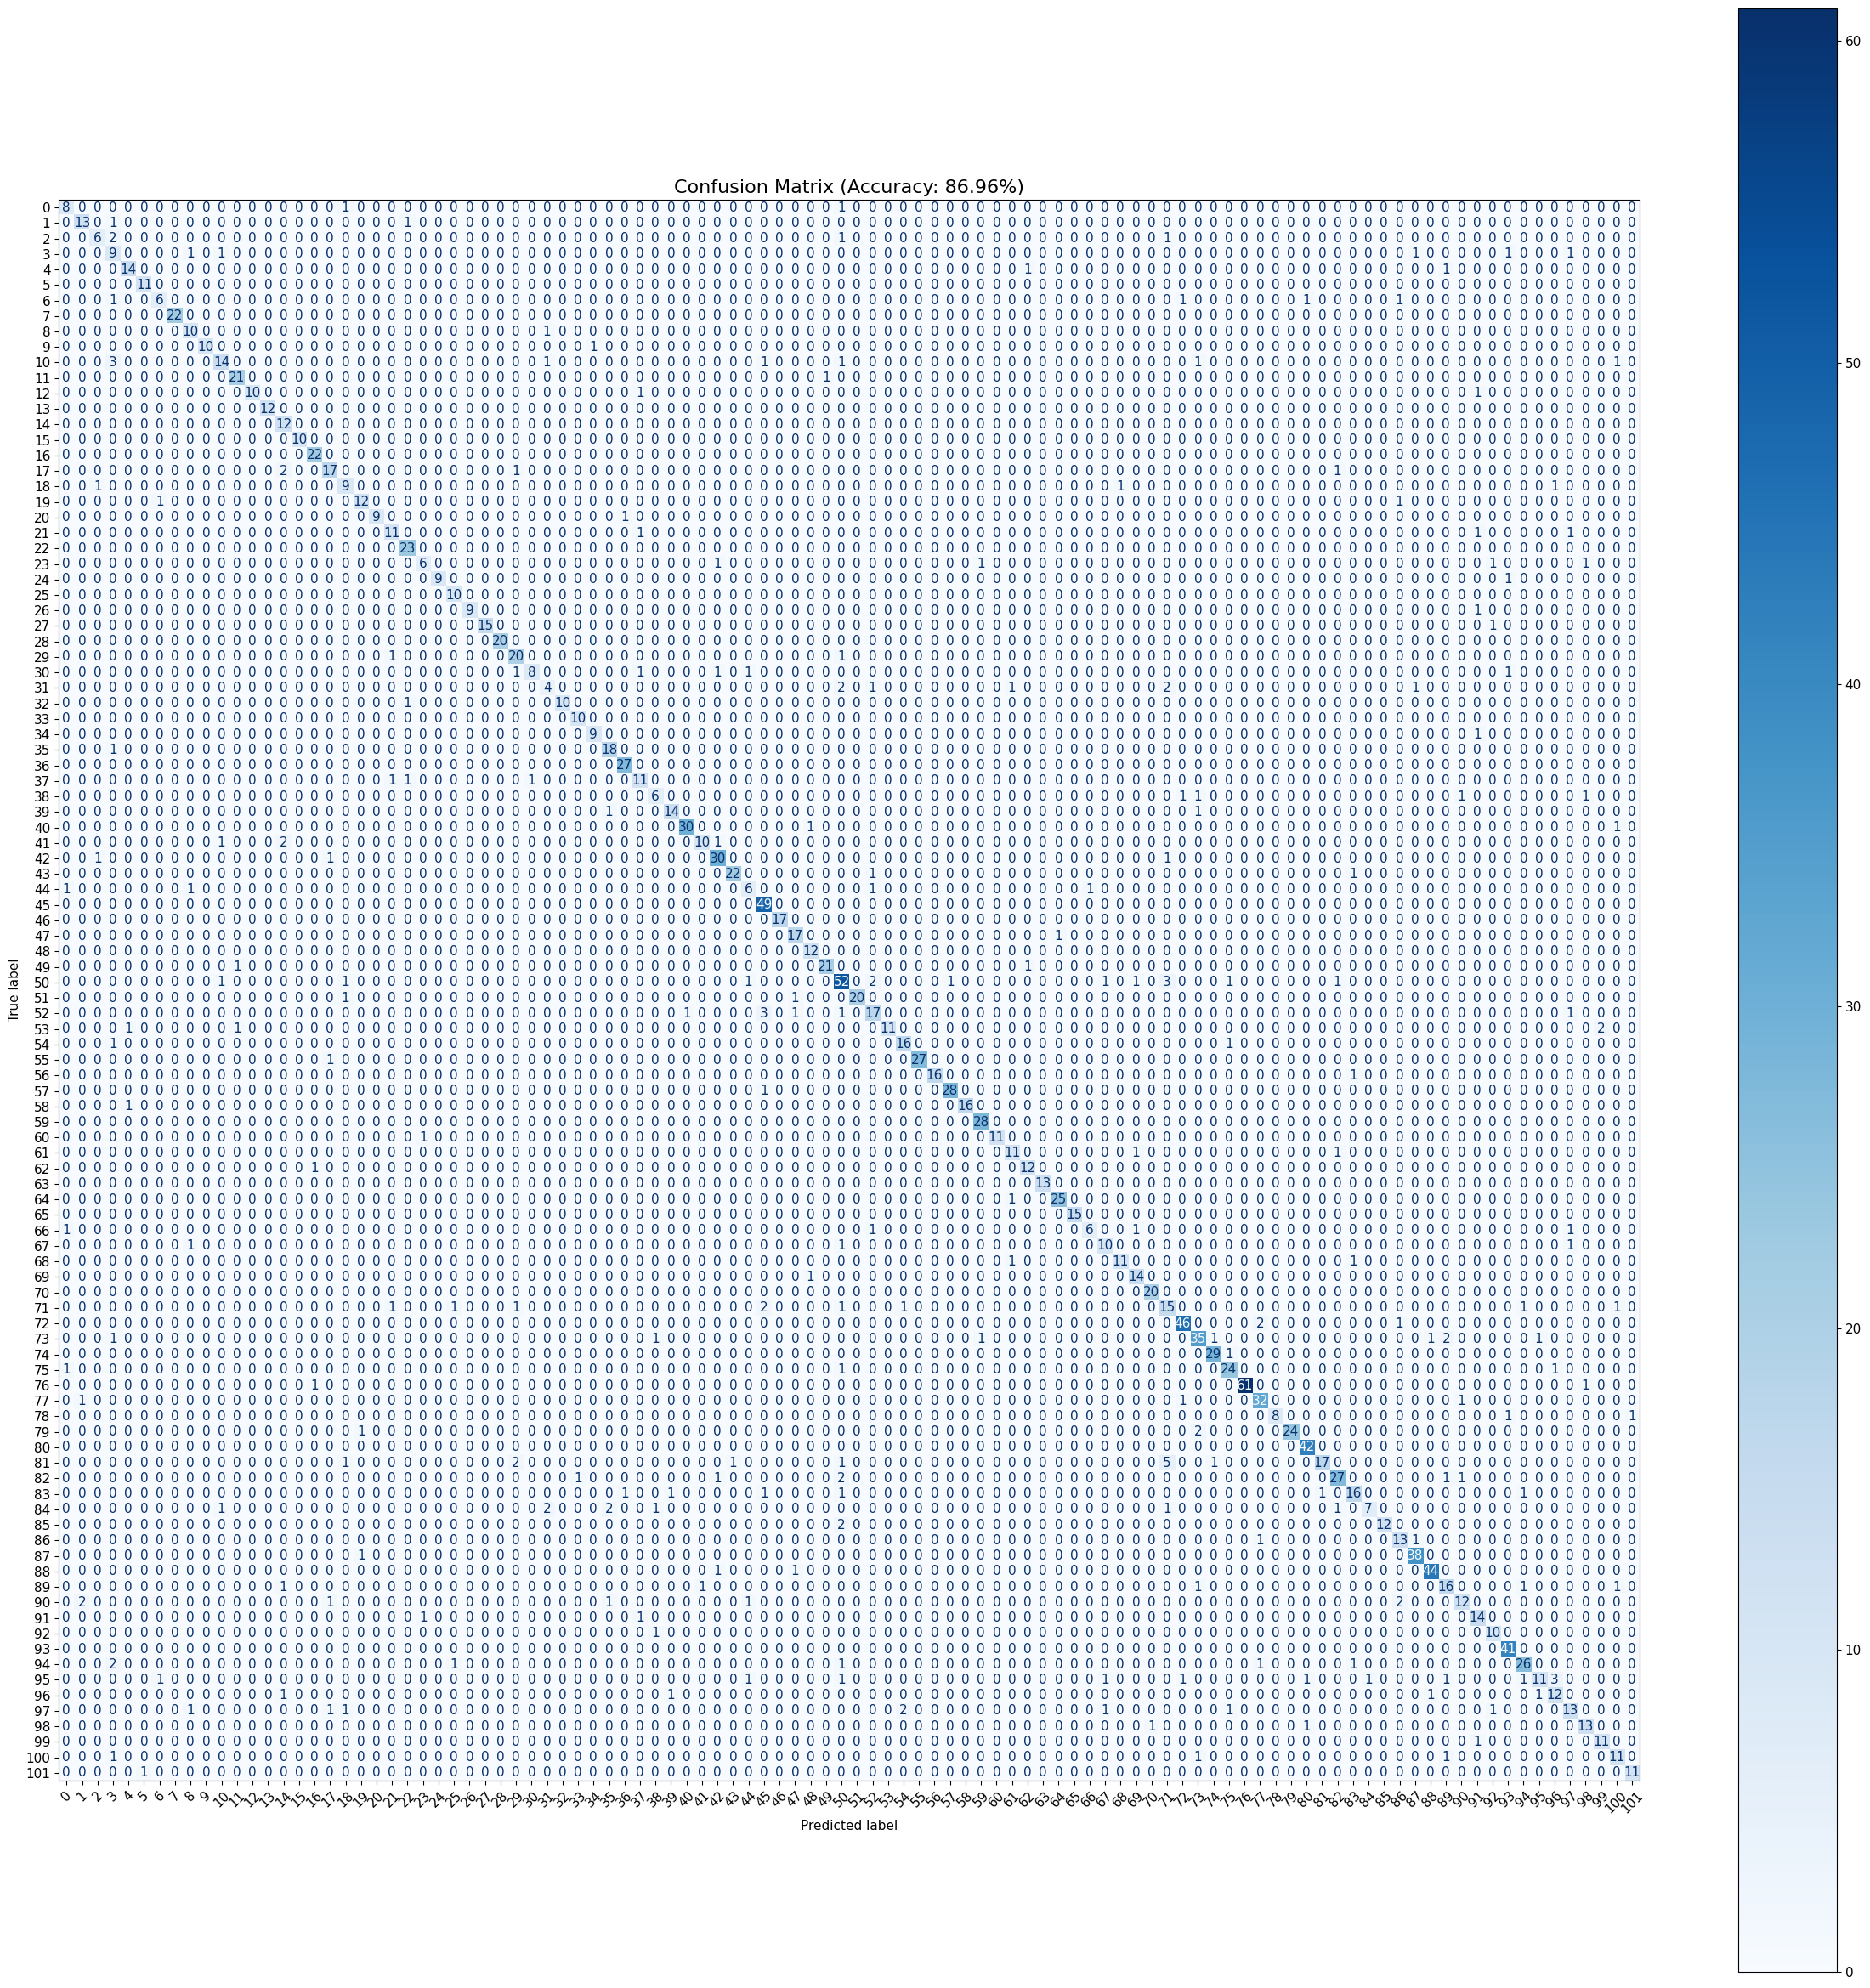

In [110]:
evaluate_model(vgg19_model, test_loader)

## train yolov5

In [112]:
display("Training YOLOv5 model...")
!python /content/yolov5/classify/train.py --model yolov5s-cls.pt --data /content/flowers102/dataset --epochs 100 --img 224 --name yolov5s_flower_classifier

'Training YOLOv5 model...'

In [113]:
yolo_results_df = pd.read_csv("/content/yolov5/runs/train-cls/yolov5s_flower_classifier/results.csv")
yolo_results_df.rename(columns=lambda col: col.strip(), inplace=True)
yolo_train_losses, yolo_train_accuracies, yolo_val_losses, yolo_val_accuracies = (
  yolo_results_df["train/loss"].tolist(),
  yolo_results_df["metrics/accuracy_top5"].tolist(),
  yolo_results_df["val/loss"].tolist(),
  yolo_results_df["metrics/accuracy_top5"].tolist()
)

In [114]:
yolo_results_df

,epoch,train/loss,val/loss,metrics/accuracy_top1,metrics/accuracy_top5,lr/0
0,0,1.65820,1.16820,0.94040,0.99316,0.00099
1,1,1.31650,1.05700,0.95994,0.99414,0.00098
2,2,1.24250,1.03780,0.95603,0.99267,0.00097
3,3,1.21490,1.06990,0.95359,0.99316,0.00096
4,4,1.19330,1.00510,0.96629,0.99511,0.00095
...,...,...,...,...,...,...
95,95,0.87602,0.86649,0.98144,0.99805,0.00005
96,96,0.87715,0.86640,0.98192,0.99805,0.00004
97,97,0.87905,0.86626,0.98192,0.99805,0.00003
98,98,0.87633,0.86615,0.98192,0.99805,0.00002


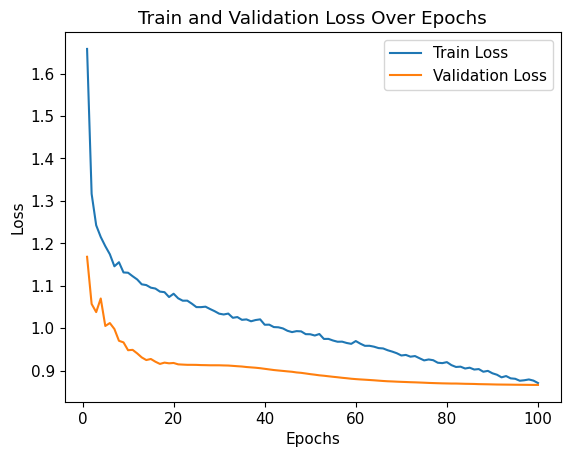

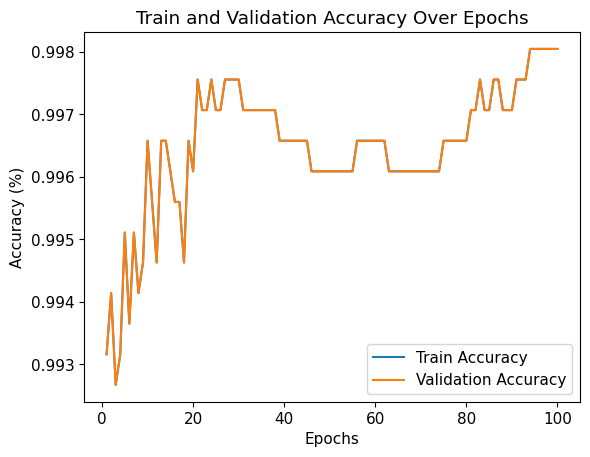

In [115]:
plot_training_statistics(yolo_train_losses, yolo_train_accuracies, yolo_val_losses, yolo_val_accuracies)

### eval models

In [116]:
yolov5_model = torch.hub.load('ultralytics/yolov5', 'custom', 'yolov5/runs/train-cls/yolov5s_flower_classifier/weights/best.pt')

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-2-1 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)

Fusing layers... 
Model summary: 117 layers, 4297350 parameters, 0 gradients, 10.5 GFLOPs
WARNING ⚠️ YOLOv5 ClassificationModel is not yet AutoShape compatible. You must pass torch tensors in BCHW to this model, i.e. shape(1,3,224,224).


In [117]:
from torchinfo import summary
model_summary = summary(yolov5_model, input_size=(1, 3, 224, 224), depth=10, col_names=["input_size", "output_size", "num_params"], verbose=0)

# Write summary to a text file
with open("yolov5_summary.txt", "w") as f:
    f.write(str(model_summary))

In [124]:
import sys
original_stdout = sys.stdout
with open("validation_script_results.txt", "w") as f:
  sys.stdout = f
  !python /content/yolov5/classify/val.py --weights yolov5/runs/train-cls/yolov5s_flower_classifier/weights/best.pt --data /content/flowers102/dataset
sys.stdout = original_stdout  # Restore original stdout

# Display the contents of the file:
!cat validation_script_results.txt

In [125]:
import sys
original_stdout = sys.stdout
# this runs it on the test
with open("test_script_results.txt", "w") as f:
  sys.stdout = f
  !python /content/yolov5/classify/val.py --weights yolov5/runs/train-cls/yolov5s_flower_classifier/weights/best.pt --data /content/flowers102
sys.stdout = original_stdout  # Restore original stdout

# Display the contents of the file:
!cat test_script_results.txt


In [126]:
import sys
original_stdout = sys.stdout
# this runs it on a specific dir (class)
with open("test_on_class_50_results.txt", "w") as f:
  sys.stdout = f
  !python /content/yolov5/classify/predict.py --weights yolov5/runs/train-cls/yolov5s_flower_classifier/weights/best.pt --source /content/flowers102/test/50
sys.stdout = original_stdout  # Restore original stdout

# Display the contents of the file:
!cat test_on_class_50_results.txt

